# Robotic arm control with MuJoCo

In this tutorial we will demonstrate how to control a robotic arm using the Collimator library and the MuJoCo physics engine. We will use the Franka Emika Panda robotic arm to pick up a block and set it on a table.  The multibody dynamics are handled with MuJoCo, but the controller is implemented in Collimator.  This can be done either in the UI or directly with the Python library.  This notebook is a standalone implementation with the Python library, but at the end we will also note how to do the same thing in the UI.

In [1]:
import numpy as np
from scipy.spatial import transform
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import collimator
from collimator import library
from collimator.backend import io_callback

# If needed, enable offscreen rendering (eg. for CI)
# import os
# os.environ['MUJOCO_GL'] = 'egl'

import mujoco
import mediapy

To get started, we will need to download and extract the MuJoCo scene definition: a collection of XML and STL files that define the robot and surrounding environment.  This .zip file should be extracted to a directory called `assets` in the same directory as the notebook.

In [2]:
from IPython.display import HTML

# Create a custom download link
HTML('<a href="assets.zip" download>Click here to download the MuJoCo scene definition assets</a>')

In order to render the scene and videos, you will also need to have ffmpeg installed.  If not found automatically, the path can be set as follows:

In [3]:
# Uncomment and change to your ffmpeg path, if needed:
# mediapy.set_ffmpeg("/opt/homebrew/bin/ffmpeg")

Let's start by checking that we can directly load and render the scene.  We should see the robotic arm in its "home" position about halfway between the orange "target" block and the grey "table" block.  Our goal will be to pick up the block and set it on the table.

collimator:INFO Initialized MuJoCo from model file 'assets/franka_emika_panda/scene.xml' with dt=0.01, 16 generalized positions, 15 generalized velocities, and 0 actuators. The default control input vector (nu=8) is:
np.array([0.0, 0.0, 0.0, -1.57079, 0.0, 1.57079, -0.7853, 255.0])
libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init


""

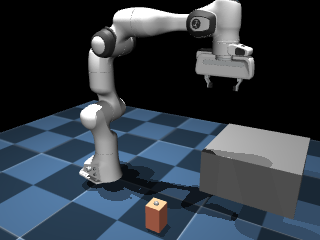

In [4]:
mjmodel = library.mujoco.MuJoCo(
    file_name="assets/franka_emika_panda/scene.xml",
    key_frame_0="home",
    enable_video_output=True,
)

frame = mjmodel.render()

mediapy.show_image(frame)

### Pick and place with differential inverse kinematics

The basic "pick-and-place" problem is to use a robotic arm to pick up an object and then put it somewhere else.  The main technical difficulty in this problem is that we control the degrees of freedom of the arm (seven for the Panda, plus one for the gripper), but we would most naturally specify the desired trajectory in Cartesian coordinates of the end-effector "hand".

A standard solution to this problem is inverse kinematics, where we use the Jacobian that relates the joint velocities $\dot{q}$ to the spatial velocity $v_h$ of the hand.  Specifically,

$$
J_h(q) \dot{q} = v_h.
$$

For a small time step $\Delta t$, we could also use this to relate a deviation from a specified command position $\Delta x_h$ to a small change in joint angles $\Delta q$:

$$
J_h(q) \Delta q \approx \Delta x_h,
$$

where $\Delta x_h = v_h \Delta t$ defines the error in both the Cartesian position and the orientation (here the "orientation error" is angular velocity times the small time step).  For the inverse problem we can compute $\Delta x_h$ easily and want to determine $\Delta q$.  This linear system is overdetermined, so we can solve with the pseudoinverse to get a minimum-norm solution:

$$
\Delta q = J_h^\dagger(q) \Delta x_h.
$$

Defining the command trajectory of the hand as $\hat{x}_h(t)$ and the current hand position as $x_h(t)$, we can define the error $\Delta x_h = \hat{x}_h - x_h$ and use the inverse kinematics to compute the joint position error $\Delta q$.

The joints are torque-controlled, so given the "joint position error" $\Delta q$ we can apply PID feedback control on the joint torques to attempt to drive $\Delta q$ to zero.

From there, the pick-and-place problem is largely a matter of bookkeeping in defining the desired trajectory so that the arm can safely pick up the object and doesn't run into anything en route to the target location.  In this notebook we will use a simple piecewise linear trajectory with a fixed orientation of the end-effector.

### Preliminary setup

First we need to extract some key entity IDs from the MuJoCo model defined in the XML file.  The easiest way to do this is to just load the model using MuJoCo directly and then get the IDs.  Under the hood the Collimator block will do the exact same thing, but doing this up front lets us do a little analysis and use the IDs to define output port functions.

In [5]:
model = mujoco.MjModel.from_xml_path("assets/franka_emika_panda/scene.xml")

hand_id = model.body("hand").id  # The end effector ID
target_id = model.site("target").id  # The block ("target") ID

# Actuators for controlled joints
arm_actuator_names = [
    "actuator1",
    "actuator2",
    "actuator3",
    "actuator4",
    "actuator5",
    "actuator6",
    "actuator7",
]
arm_actuator_ids = np.array([model.actuator(name).id for name in arm_actuator_names])
grip_actuator_id = model.actuator("actuator8").id  # Tendon for the end-effector gripper

Next we can create the main MuJoCo block.  Currently the default output ports are the joint position (`qpos`), joint velocity (`qvel`), and actuator state (`act`), but additional ports can be defined by creating short "scripts" that accept the MuJoCo model and data struct as arguments.  Here we will use the Cartesian position (`xpos`) and orientation (`xquat`) of the end-effector along with the Jacobian for this body in the inverse kinematics calculation, and the Cartesian position and orientation (`xmat`) of the target block for post-processing and creating the video later on.

In [6]:
dt = 0.001

jac_buffer = np.zeros((6, model.nv))
def jac_script(model, data):
    mujoco.mj_jacBody(model, data, jac_buffer[:3], jac_buffer[3:], hand_id)
    return jac_buffer

custom_outputs = {
    "hand_xpos": lambda model, data: data.body(hand_id).xpos,
    "hand_xquat": lambda model, data: data.body(hand_id).xquat,
    "target_xpos": lambda model, data: data.site(target_id).xpos,
    "target_xmat": lambda model, data: data.site(target_id).xmat,
    "jac": jac_script,
}

mjmodel = library.mujoco.MuJoCo(
    file_name="assets/franka_emika_panda/scene.xml",
    dt=dt,
    key_frame_0="home",
    enable_video_output=True,
    custom_output_scripts=custom_outputs,
)
data = mjmodel._data

collimator:INFO Initialized MuJoCo from model file 'assets/franka_emika_panda/scene.xml' with dt=0.001, 16 generalized positions, 15 generalized velocities, and 0 actuators. The default control input vector (nu=8) is:
np.array([0.0, 0.0, 0.0, -1.57079, 0.0, 1.57079, -0.7853, 255.0])


The trajectory for this "pick-and-place" task will be a piecewise linear interpolation between a series of waypoints.  The arm should move to a "pre-grasp" position that's clear of the block, into grasping position, close the gripper, return to pregrasp position, safely move to a "pre-place" position, the place position, open the gripper, and finally return home.

For this simple example there is no need to change the orientation of the object, so we can simply use the "home" orientation of the end-effector as a target orientation throughout the entire task.

In [7]:
# Define key locations in the scene
home_pos = data.body(hand_id).xpos.copy()
u0 = data.ctrl[arm_actuator_ids].copy()
target_pos = data.site(target_id).xpos.copy()
pregrasp_pos = target_pos + np.array([-0.035, 0.0, 0.15])
grasp_pos = target_pos + np.array([-0.035, 0.0, 0.05])
waypoint_pos = home_pos + np.array([0.0, 0.0, -0.1])
preplace_pos = np.array([0.6, 0.35, 0.5])
place_pos = preplace_pos + np.array([0.0, 0.0, -0.12])

We can use a simple linear interpolant to get the command position as a function of time, and also define a block to output the gripper command.

In [8]:
# Custom block to output piecewise linear target locations
OPEN = np.array(0)
CLOSE = np.array(1)

# Motion stages (times are cumulative in seconds)
scale = 2.0
t0 = 0.0
time_array = np.array([
    0.0,  # Home
    2.0,  # Pre-grasp
    3.0,  # Grasp
    3.5,  # Close gripper (grasp)
    4.5,  # Pre-grasp
    7.5,  # Waypoint
    9.0,  # Pre-place
    10.0,  # Place
    10.5,  # Open gripper (place)
    11.5,  # Pre-place
    13.0,  # Home
]) / scale
tf = time_array[-1]

xpos_array = np.array([
    home_pos,
    pregrasp_pos,
    grasp_pos,
    grasp_pos,
    pregrasp_pos,
    waypoint_pos,
    preplace_pos,
    place_pos,
    place_pos,
    preplace_pos,
    home_pos,
])

# vmap interpolation to allow for 2d array input
interp_fun = jax.vmap(jnp.interp, (None, None, 1))

def pos_command_cb(time):
    t = time - t0
    return jnp.where((t < 0.0) | (t > tf), home_pos, interp_fun(t, time_array, xpos_array))

def grip_command_cb(time):
    t = time - t0
    return jnp.where((t > time_array[2]) & (t < time_array[7]), 0.0, 255.0)

pos_source = library.SourceBlock(pos_command_cb, name="pos_command")
grip_source = library.SourceBlock(grip_command_cb, name="grip_command")

The last bit of custom machinery we have to implement is the inverse kinematics.  Here we'll use a standard pseudoinverse calculation to get the tracking error in position and orientation (we will not approach any singularities).  Since the arm is torque-controlled, we will then be able to apply parallel PID controllers to each joint to apply torque such that the tracking error is driven to zero.

In [9]:
# Custom class for inverse kinematics

class InverseKinematics(collimator.LeafSystem):
    def __init__(self, nv, name="InverseKinematics"):
        super().__init__(name=name)

        # Preallocate some arrays for computing inverse kinematics
        self.error = np.zeros(6)
        self.hand_quat = np.zeros(4)
        self.hand_quat_conj = np.zeros(4)
        self.error_quat = np.zeros(4)

        # Create input ports
        self.declare_input_port("target_pos")
        self.declare_input_port("target_quat")
        self.declare_input_port("pos")
        self.declare_input_port("quat")
        self.declare_input_port("jac")

        # Output port: joint velocities
        def _output_cb(time, state, *inputs, **parameters):
            return io_callback(self._diffik, np.zeros(nv), *inputs)

        self.declare_output_port(_output_cb, period=dt)

    def _diffik(self, target_pos, target_quat, pos, quat, jac):
        # Compute the error in position and orientation
        self.error[:3] = target_pos - pos
        mujoco.mju_negQuat(self.hand_quat_conj, quat)
        mujoco.mju_mulQuat(self.error_quat, target_quat, self.hand_quat_conj)
        mujoco.mju_quat2Vel(self.error[3:], self.error_quat, 1.0)

        # Solve system of equations: J @ dq = dx
        return np.linalg.pinv(jac) @ self.error

We're finally ready to construct the full block diagram.  In the app, the model would look like this:

<img src="../media/mj_pnp_diagram.png" alt="diagram" style="width: 500px;"/>

Constructing the system in code there are some minor differences, but the overall controller structure is largely the same.  The following code uses the Collimator `DiagramBuilder` interface to programmatically construct this model.  Evidently, this approach quickly becomes unwieldy in code and is not recommended for larger models; it is much easier and less error-prone to construct larger block diagrams in the [Collimator web UI](app.collimator.ai) (see notes on UI implementation at the end of the tutorial).

In [10]:

builder = collimator.DiagramBuilder()
builder.add(mjmodel, grip_source, pos_source)

# Constant orientation for the end-effector
rot = transform.Rotation.from_euler("xyz", [90, 0, 180], degrees=True)
const_q0 = builder.add(library.Constant(rot.as_quat(), name="q0"))

# Inverse kinematics
ik = builder.add(InverseKinematics(nv=mjmodel.nv))
builder.connect(pos_source.output_ports[0], ik.input_ports[0])  # Target position
builder.connect(const_q0.output_ports[0], ik.input_ports[1])  # Target orientation
builder.connect(mjmodel.get_output_port("hand_xpos"), ik.input_ports[2])  # Current position
builder.connect(mjmodel.get_output_port("hand_xquat"), ik.input_ports[3])  # Current orientation
builder.connect(mjmodel.get_output_port("jac"), ik.input_ports[4])  # Jacobian

# Extract only the controlled joints from the inverse kinematics
dq_arm = builder.add(library.FeedthroughBlock(lambda dq: dq[arm_actuator_ids], name="dq_arm"))
builder.connect(ik.output_ports[0], dq_arm.input_ports[0])
demux_dq = builder.add(library.Demultiplexer(len(arm_actuator_ids), name="demux_dq"))
builder.connect(dq_arm.output_ports[0], demux_dq.input_ports[0])

# Replicate PID controllers for each joint
pid = builder.add(library.Multiplexer(len(arm_actuator_ids), name="pid"))
for i in range(len(arm_actuator_ids)):
    pid_i = builder.add(library.PIDDiscrete(kp=10.0, ki=1.0, kd=0.01, dt=dt))
    builder.connect(demux_dq.output_ports[i], pid_i.input_ports[0])
    builder.connect(pid_i.output_ports[0], pid.input_ports[i])

# Add the base control signal to the PID output
adder_uq = builder.add(library.Adder(2, name="uq"))  # Joint commands
const_uq0 = builder.add(library.Constant(mjmodel.ctrl_0[arm_actuator_ids], name="uq0"))
builder.connect(const_uq0.output_ports[0], adder_uq.input_ports[0])
builder.connect(pid.output_ports[0], adder_uq.input_ports[1])

# Append the gripper command to the joint commands
mux_u = builder.add(library.Multiplexer(2, name="u"))
builder.connect(adder_uq.output_ports[0], mux_u.input_ports[0])
builder.connect(grip_source.output_ports[0], mux_u.input_ports[1])

builder.connect(mux_u.output_ports[0], mjmodel.input_ports[0])

system = builder.build()
system.pprint()

│── root <Diagram>
    │── MuJoCo_2_ <MuJoCo> [hand_xpos → InverseKinematics.pos, hand_xquat → InverseKinematics.quat, jac → InverseKinematics.jac]
    │── grip_command <SourceBlock> [out_0 → u.in_1]
    │── pos_command <SourceBlock> [out_0 → InverseKinematics.target_pos]
    │── q0 <Constant> [out_0 → InverseKinematics.target_quat]
    │── InverseKinematics <InverseKinematics> [out_0 → dq_arm.in_0]
    │── dq_arm <FeedthroughBlock> [out_0 → demux_dq.in_0]
    │── demux_dq <Demultiplexer> [out_0 → PIDDiscrete_10_.in_0, out_1 → PIDDiscrete_11_.in_0, out_2 → PIDDiscrete_12_.in_0, out_3 → PIDDiscrete_13_.in_0, out_4 → PIDDiscrete_14_.in_0, out_5 → PIDDiscrete_15_.in_0, out_6 → PIDDiscrete_16_.in_0]
    │── pid <Multiplexer> [out_0 → uq.in_1]
    │── PIDDiscrete_10_ <PIDDiscrete> [out_0 → pid.in_0]
    │── PIDDiscrete_11_ <PIDDiscrete> [out_0 → pid.in_1]
    │── PIDDiscrete_12_ <PIDDiscrete> [out_0 → pid.in_2]
    │── PIDDiscrete_13_ <PIDDiscrete> [out_0 → pid.in_3]
    │── PIDDiscrete_14_

### Simulation

Now we can run the full simulation including the control loop as usual in Collimator.  We'll record everything we need to re-create a video of the arm performing the placement task in postprocessing.

In [11]:
context = system.create_context()

recorded_signals = {
    "qpos": mjmodel.output_ports[0],
    "pos_cmd": pos_source.output_ports[0],
    "hand_xpos": mjmodel.get_output_port("hand_xpos"),
    "target_xpos": mjmodel.get_output_port("target_xpos"),
    "target_xmat": mjmodel.get_output_port("target_xmat"),
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
) 

collimator:INFO max_major_steps=12998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=12998, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=5, return_context=True), Dopri5Solver(system=Diagram(root, 18 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


Now we can plot the planned versus actual position of the end-effector to make sure the intended trajectory is being followed.  On its own this is not the most intuitive way to assess the performance of the controller; next we will render the scene and create a video of the arm performing the task.

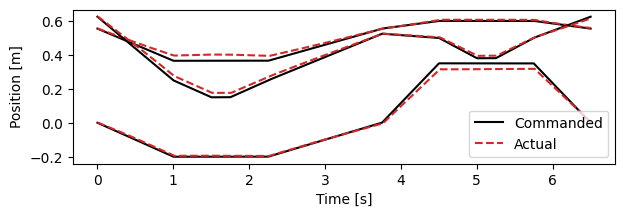

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 2), sharex=True)

for i in range(3):
    ax.plot(results.time, results.outputs["pos_cmd"][:, i], c='k')
    ax.plot(results.time, results.outputs["hand_xpos"][:, i], '--', c='tab:red')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.legend(["Commanded", "Actual"])
plt.show()

### Post-processing

Finally, since the "scene" can be fully reconstructed with the joint positions and the position and orientation of the target block, we can create a video as a post-processing step by interpolating the recorded data.  The control loop ran at 1kHz, which is an unnecessarily high frame rate, so in this step we downsample to 60 frames per second and use the MuJoCo renderer to create an RGB array for each frame.

In [13]:
# Time stamps for scene
fps = 60.0
t = np.arange(0, tf, 1/fps)

# Linearly interpolate the joint positions
qpos = np.zeros((len(t), mjmodel.nq))
for i in range(mjmodel.nq):
    qpos[:, i] = np.interp(t, results.time, results.outputs["qpos"][:, i])

block_xpos = np.zeros((len(t), 3))
for i in range(3):
    block_xpos[:, i] = np.interp(t, results.time, results.outputs["target_xpos"][:, i])

block_xmat = np.zeros((len(t), 9))
for i in range(9):
    block_xmat[:, i] = np.interp(t, results.time, results.outputs["target_xmat"][:, i])

frames = np.zeros((len(t), *mjmodel._video_default.shape), dtype=np.uint8)
for i, q in enumerate(qpos):
    data.qpos[:] = q
    data.site_xpos[target_id] = block_xpos[i]
    data.site_xmat[target_id] = block_xmat[i]
    mujoco.mj_kinematics(model, data)
    frames[i] = mjmodel.render(data)


mediapy.show_video(frames, fps=fps, loop=False)

# Implementing in the UI

If you want to implement this in the [Collimator web app](app.collimator.ai), you can follow essentially the same steps, but with a few key differences.


### Preliminary setup

First, all the "assets" should be uploaded to the project directory.  Since the UI doesn't support directory structures, you can just upload all the files to the main folder and remove the "assets/franka_emika_panda" prefix from the XML file.

Now the preliminary configuration (defining waypoints, etc.) can be done in an "init script":

```python

import numpy as np
from scipy.spatial import transform
import mujoco

import jax
import jax.numpy as jnp

model = mujoco.MjModel.from_xml_path("scene.xml")

hand_id = model.body("hand").id  # The end effector ID
target_id = model.site("target").id  # The block ("target") ID

# Actuators for controlled joints
arm_actuator_names = [
    "actuator1",
    "actuator2",
    "actuator3",
    "actuator4",
    "actuator5",
    "actuator6",
    "actuator7",
]
arm_actuator_ids = np.array([model.actuator(name).id for name in arm_actuator_names])
grip_actuator_id = model.actuator("actuator8").id  # Tendon for the end-effector gripper

# Define key locations in the scene
home_pos = np.array([5.54499478e-01, 0.0,  6.24502429e-01])
u0 = np.array([ 0.     ,  0.     ,  0.     , -1.57079,  0.     ,  1.57079,   -0.7853 ])
target_pos = np.array([0.4, -0.2,  0.1])
pregrasp_pos = target_pos + np.array([-0.035, 0.0, 0.15])
grasp_pos = target_pos + np.array([-0.035, 0.0, 0.05])
waypoint_pos = home_pos + np.array([0.0, 0.0, -0.1])
preplace_pos = np.array([0.6, 0.35, 0.5])
place_pos = preplace_pos + np.array([0.0, 0.0, -0.12])

# Motion stages (times are cumulative in seconds)
t0 = 0.0
time_array = np.array([
    0.0,  # Home
    1.0,  # Pre-grasp
    1.5,  # Grasp
    1.75,  # Close gripper (grasp)
    2.25,  # Pre-grasp
    3.75,  # Waypoint
    4.5,  # Pre-place
    5.0,  # Place
    5.25,  # Open gripper (place)
    5.75,  # Pre-place
    6.5,  # Home
])
tf = time_array[-1]

xpos_array = np.array([
    home_pos,
    pregrasp_pos,
    grasp_pos,
    grasp_pos,
    pregrasp_pos,
    waypoint_pos,
    preplace_pos,
    place_pos,
    place_pos,
    preplace_pos,
    home_pos,
])
```

### Defining the MuJoCo plant

The MuJoCo multibody plant can be created by simply selecting `scene.xml` from the dropdown menu in the MuJoCo block.  Be sure to set the timestep to the same value used as the "discrete clock tick" in the simulation settings (here we used $\Delta t = 0.001$).  The initial key frame should also be set to `"home"` so that the model is initialized in the correct position (otherwise by default all joint angles are zero).

The custom output ports can be defined as above.  For instance, you can create an output port named `hand_xpos` with the script:

```python
fn = lambda model, data: data.body(9).xpos
```

and likewise for the `hand_xquat` port.  Note that the function _must_ be named `fn`.  The `target_xpos` and `target_xmat` ports can be defined similarly, e.g. for `target_xpos`:

```python
fn = lambda model, data: data.site(0).xpos
```

For the Jacobian calculation, we will need to explicitly import NumPy and MuJoCo in order to define the function and allocate the buffer array:

```python
import numpy as np
import mujoco
jac_buffer = np.zeros((6, 15))

def fn(model, data):
    mujoco.mj_jacBody(model, data, jac_buffer[:3], jac_buffer[3:], 9)
    return jac_buffer
```

However, only the `fn` function will be evaluated online, so this will use the preallocated buffer and will not need to re-import NumPy and MuJoCo.

__NOTE:__ Currently the JAX implementation of MuJoCo (called [MJX](https://mujoco.readthedocs.io/en/stable/mjx.html)) does not support some of the features used in this demo (such as the Jacobian calculation and the tendon joint for the Panda end-effector), so the "Use mjx" option should be unchecked in the MuJoCo block settings.

### Command trajectory

The trajectory generation is also similar to what we did in code, but we will use PythonScript blocks with a single input port (time).  For instance, the `PositionCommand` block can be implemented with the following code:

__Init__:
```python
import jax
import jax.numpy as jnp
interp = jax.vmap(jnp.interp, (None, None, 1))
```

__Step__:
```python
t = time - t0
xpos_command = interp(t, time_array, xpos_array)
xpos_command = jnp.where((t < 0.0) | (t > tf), home_pos, xpos_command)
```

Likewise, the `GripCommand` block can be implemented as follows:

__Init__:
```python
import jax.numpy as jnp
```

__Step__:
```python
t = time - t0
grip_command = jnp.where((t > time_array[2]) & (t < time_array[7]), 0.0, 255.0)
```

Be sure to create block parameters for `t0`, `tf`, `time_array`, etc. in the block configuration and check the "Accelerate with JAX" option.  Even though the MuJoCo plant will not use JAX, there is still a significant speedup over NumPy when using JAX wherever possible.

### Inverse kinematics

This is implemented as another PythonScript block.  However, in contrast to the trajectory sources, here we will call the MuJoCo functions to compute the position and orientation errors, so we cannot use JAX.  Instead, uncheck "Accelerate with JAX" and select the "Discrete" time mode so that the control loop runs at the same rate as the MuJoCo plant.  We will have five inputs: `target_pos`, `target_quat`, `pos`, `quat`, and `jac`.  The output will be the joint tracking error `dq`.

__Init__:
```python
import numpy as np
import mujoco

# Preallocate buffer arrays
error = np.zeros(6)
hand_quat_conj = np.zeros(4)
error_quat = np.zeros(4)
dq = np.zeros(15)  # Get from model.nv
```

__Step__:
```python
# Compute the error in position and orientation
error[:3] = target_pos - pos
mujoco.mju_negQuat(hand_quat_conj, quat)
mujoco.mju_mulQuat(error_quat, target_quat, hand_quat_conj)
mujoco.mju_quat2Vel(error[3:], error_quat, 1.0)

# Solve system of equations: J @ dq = dx.
dq = np.linalg.pinv(jac) @ error
```

Otherwise, the UI implementation is largely the same as what we did above using the Python library.
